In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom

In [2]:
# img = dicom.dcmread("../data/PAT034/D0001.dcm").pixel_array
img = np.ones((9, 7)) * 150
img[0:2] = 50
height, width = img.shape
half_height = height//2
half_width = width//2



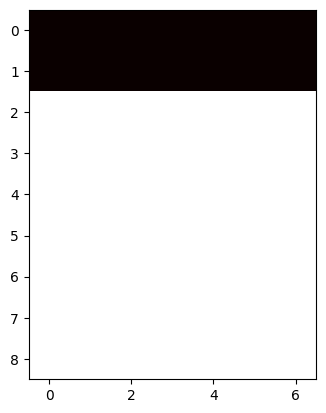

In [3]:
plt.imshow(img, cmap="hot",aspect=1)

In [4]:
def rotate_matrix(degree:float):
    theta = degree * (np.pi/180)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    matrix = np.array([ [cos_theta, -sin_theta],
                       [sin_theta, cos_theta] ])
    
    return matrix

rotate_matrix(45)

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

# Get rotated image size
- To determine the size of an image, we need at least 3 point. <br>
 => Get the coordinate of 3 corner point (with the origin at the center of image)
<i>(Ex: Upper left, Upper right, Lower Right)</i>

- The idea here is to rotate 3 corner point with the rotation matrix and we will have the new size of rotated image<br>
<b><i>Multiply matrix: Rotation_matrix @ corners</i></b>

In [5]:
upper_left = [-half_width, half_height] # (x, y)
upper_right = [half_width, half_height]
lower_right = [half_width, -half_height]

# convert the coordinates above to a matrix that is multiplicable by rotation_matrix (2x2)

# corners = np.array([upper_left, upper_right, lower_right]) => Not working because this is (3x2) matrix

corners = np.array([upper_left, upper_right, lower_right]).transpose() 
corners

array([[-3,  3,  3],
       [ 4,  4, -4]])

- Rotate the corner points

In [6]:
# test rotate
degree = 45
new_corners = rotate_matrix(degree) @ corners
new_corners

array([[-4.94974747, -0.70710678,  4.94974747],
       [ 0.70710678,  4.94974747, -0.70710678]])

- To get the greatest deviation from the center of an image (The farthest point from the center) with each axis, we need to find the maximum value in both x and y axis <br>
<b>=> Rotated Image dimension: (max(x) * 2, max(y) * 2)</b>

In [7]:
'''
new_corners = [ [x1,x2,...,xn]
                [y1,y2,...,yn] ]
'''
half_rotated_width = max(abs(new_corners[1]))
half_rotated_height = max(abs(new_corners[0]))

- because we are working with matrix (rows and columns) we need to round them to int

In [8]:
half_rotated_width = int(half_rotated_width)
half_rotated_height = int(half_rotated_height)

rotated_width = half_rotated_width * 2
rotated_height = half_rotated_height * 2
half_rotated_height

4

# Rotate Image

- Define the rotated image matrix and fill it with 0

In [9]:
rotated_img = np.zeros((rotated_height, rotated_width))
rotated_img.shape

(8, 8)

- To rotate the image, we need to <b><i> reverse thinking</i></b>: <br>
-- Instead of finding the location for each pixel of original image after rotating x degree, we take each pixel of new image and rotate it back (-x) degree and get the color value of that pixel

- np.indicies(): https://stackoverflow.com/questions/32271331/can-anybody-explain-me-the-numpy-indices <br>
 returns arrays which can be used as indices. The elements in i indicate the row index


 - Example:
 -- Create a 2x2 matrix:<br> <code>ids = np.indicies((2,2))</code> <br>
 -- Unpack the i, j indicies:<br> <code> i, j = ids </code> <br>
 -- These are the indicies i, j: <br>
  <code> print(i) </code> <br>
  [[0 0] <br>
   [1 1]] <br>
  <code> print(j) </code> <br>  
  [[0 1] <br>
 [0 1]] <br>

- The easy way to think of it is to make pairs as (i0,j0), (i1,j1), (i2,j2), (i3,j3) i.e. match each element of i with the corresponding element of j. So we get: <br>
    <table style="width:20%">
        <tr>
            <th></th>
            <th>0</th>
            <th>1</th>
        </tr>
        <tr>
            <th>0</th>
            <th>(0, 0)</th>
            <th>(0, 1)</th>
        </tr>
        <tr>
            <th>1</th>
            <th>(1, 0)</th>
            <th>(1, 1)</th>
        </tr>
    </table>


- Create the indicies arrays using rotated_img's size to store all the indexes of rotated_img matrix

In [10]:
indexes = np.indices((rotated_height, rotated_width))
indexes


array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7]],

       [[0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7]]])

#### We can apply the "reverse thinking" above by rotate each pixel <b>index</b> in rotated_img back to the original img ( rotate (-x) degree )

- In order to do that, we need to get all the x, y index of current rotated_img and apply our rotation matrix to rotate all the index 

In [11]:
y_rot_indexes = indexes[0]
x_rot_indexes = indexes[1]

x_rot_indexes



array([[0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7]])

- We need to combine x_rot and y_rot to a matrix so we can apply the rotation matrix to rotate these indexes, but there are 2 PROBLEMS:<br>
    1. The size of rotate matrix is (2 x 2), if we combine x_rot and y_rot right now, we not gonna have a (2 x n) matrix form, so we cant do a matrix multiplication
    2. The rotate matrix we defined above is using the origin at the middle of the img (matrix) , but with the index in coding, the origin of the rotated_img matrix is at the upper left of the matrix, so we cant just apply the rotate yet

In [12]:
# Cant combine right now because look at the shape!
np.row_stack((x_rot_indexes, y_rot_indexes)).shape

(16, 8)

1. To reduce the dimension of the matrix, we use flatten() to flat the matrix n-dim to 1-dim

In [13]:
y_rot_indexes = y_rot_indexes.flatten()
x_rot_indexes = x_rot_indexes.flatten()
print(x_rot_indexes.shape)
print(y_rot_indexes.shape)

np.row_stack((x_rot_indexes, y_rot_indexes))

(64,)
(64,)


array([[0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5,
        6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3,
        4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7]])

2. We subtract the indexes by half the width and length of the rotated_img to get the origin point index to the middle of the matrix <br>
=> Now we can combine these 2 indexes

In [28]:
y_rot_center_indexes = y_rot_indexes - half_rotated_height
x_rot_center_indexes = x_rot_indexes - half_rotated_width

test_x_rot = x_rot_center_indexes.reshape((rotated_height, rotated_width))
test_y_rot = y_rot_center_indexes.reshape((rotated_height, rotated_width))
print(test_x_rot)
print(test_y_rot)



rot_center_indexes = np.row_stack((x_rot_center_indexes, y_rot_center_indexes))
rot_center_indexes.shape

[[-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]
 [-4 -3 -2 -1  0  1  2  3]]
[[-4 -4 -4 -4 -4 -4 -4 -4]
 [-3 -3 -3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3]]


(2, 64)

- Now we have the indexes of the rotated_img that sastisfy our requirements: 
    + Multiplicable by our rotate_matrix
    + Origin at the middle
- After rotate, we probably gonna get some float values, but we dont care about that float, because we are working with index (int), so we convert all the floats to int using .astype(np.int32)

In [15]:
rev_rot_center_indexes = (rotate_matrix(-degree) @ rot_center_indexes).astype(np.int32) 
rev_rot_center_indexes


array([[-5, -4, -4, -3, -2, -2, -1,  0, -4, -4, -3, -2, -2, -1,  0,  0,
        -4, -3, -2, -2, -1,  0,  0,  0, -3, -2, -2, -1,  0,  0,  0,  1,
        -2, -2, -1,  0,  0,  0,  1,  2, -2, -1,  0,  0,  0,  1,  2,  2,
        -1,  0,  0,  0,  1,  2,  2,  3,  0,  0,  0,  1,  2,  2,  3,  4],
       [ 0,  0, -1, -2, -2, -3, -4, -4,  0,  0,  0, -1, -2, -2, -3, -4,
         1,  0,  0,  0, -1, -2, -2, -3,  2,  1,  0,  0,  0, -1, -2, -2,
         2,  2,  1,  0,  0,  0, -1, -2,  3,  2,  2,  1,  0,  0,  0, -1,
         4,  3,  2,  2,  1,  0,  0,  0,  4,  4,  3,  2,  2,  1,  0,  0]])

- We have the index of x and y after rotate back x degree, the full name of the variable is revert_x and revert_y, but its too long so i called them x, y instead

In [16]:
x_center_indexes = rev_rot_center_indexes[0]
y_center_indexes = rev_rot_center_indexes[1]


In [30]:
test_xc = x_center_indexes.reshape((rotated_height, rotated_width))
test_xc

array([[-5, -4, -4, -3, -2, -2, -1,  0],
       [-4, -4, -3, -2, -2, -1,  0,  0],
       [-4, -3, -2, -2, -1,  0,  0,  0],
       [-3, -2, -2, -1,  0,  0,  0,  1],
       [-2, -2, -1,  0,  0,  0,  1,  2],
       [-2, -1,  0,  0,  0,  1,  2,  2],
       [-1,  0,  0,  0,  1,  2,  2,  3],
       [ 0,  0,  0,  1,  2,  2,  3,  4]])

- Now we must convert the origin index back to the default (upper left)

In [32]:
x_indexes = x_center_indexes + half_width
y_indexes = y_center_indexes + half_height

y_indexes

array([4, 4, 3, 2, 2, 1, 0, 0, 4, 4, 4, 3, 2, 2, 1, 0, 5, 4, 4, 4, 3, 2,
       2, 1, 6, 5, 4, 4, 4, 3, 2, 2, 6, 6, 5, 4, 4, 4, 3, 2, 7, 6, 6, 5,
       4, 4, 4, 3, 8, 7, 6, 6, 5, 4, 4, 4, 8, 8, 7, 6, 6, 5, 4, 4])

- Its very tempting to do the map right now: <br>
<code>rotated_img[y_rot_indexes, x_rot_indexes] = img[y_indexes, x_indexes]</code> <br>
But remember the sizes of the original image and the rotated_img are not the same! So if you do the map right now, you gonna get out of bounds!

- So we have to check if the index of both rotated_img and original img exist:
    + x in range(0, half_width)
    + y in range(0, half_height)

- The boolean array below create an array filled with True/False based on the condition given. This array has the same shape as the rotated image and is used as a mask to selectively copy values from the original image to the rotated image.

In [19]:
boolean_array = np.logical_and(np.abs(x_center_indexes) < half_width, np.abs(y_center_indexes) < half_height)
boolean_array

array([False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
       False])

In [20]:
test = boolean_array.reshape((rotated_height,rotated_width))

for i in range(test.shape[1]):
    for j in range(test.shape[0]):
        draw = ""
        if (test[i, j] == True):
            draw = "@"
        else:
            draw = "_"
        print(draw, end=" ")
    print()

_ _ _ _ @ @ _ _ 
_ _ _ @ @ @ @ _ 
_ _ @ @ @ @ @ @ 
_ @ @ @ @ @ @ @ 
@ @ @ @ @ @ @ @ 
@ @ @ @ @ @ @ @ 
_ @ @ @ @ @ @ _ 
_ _ @ @ @ @ _ _ 


- The line below is an example of how this boolean indexing works. It will return the values of x_indexes that make the condition in the boolean array = True
- np.abs(x_center_ids) < h_width: This condition checks whether the absolute (non-negative) x-coordinate of each pixel in the rotated image is less than half of the original image's width (h_width). In other words, it verifies whether the x-coordinate of a pixel in the rotated image falls within the horizontal boundaries of the original image.
- np.abs(y_center_ids) < h_height: This condition checks whether the absolute (non-negative) y-coordinate of each pixel in the rotated image is less than half of the original image's height (h_height). It verifies whether the y-coordinate of a pixel in the rotated image falls within the vertical boundaries of the original image.

In [21]:
testx = x_indexes.reshape((rotated_height, rotated_width))
testy = y_indexes.reshape((rotated_height, rotated_width))

print(testx)
print(testy)

[[-2 -1 -1  0  1  1  2  3]
 [-1 -1  0  1  1  2  3  3]
 [-1  0  1  1  2  3  3  3]
 [ 0  1  1  2  3  3  3  4]
 [ 1  1  2  3  3  3  4  5]
 [ 1  2  3  3  3  4  5  5]
 [ 2  3  3  3  4  5  5  6]
 [ 3  3  3  4  5  5  6  7]]
[[4 4 3 2 2 1 0 0]
 [4 4 4 3 2 2 1 0]
 [5 4 4 4 3 2 2 1]
 [6 5 4 4 4 3 2 2]
 [6 6 5 4 4 4 3 2]
 [7 6 6 5 4 4 4 3]
 [8 7 6 6 5 4 4 4]
 [8 8 7 6 6 5 4 4]]


In [22]:
y_rot_exist = y_rot_indexes[boolean_array == True]
x_rot_exist = x_rot_indexes[boolean_array == True]

y_exist = y_indexes[boolean_array == True]
x_exist = x_indexes[boolean_array == True]

In [23]:
y_exist.shape

(45,)

In [24]:
y_rot_exist.shape

(45,)

In [25]:
# rotated_img[y_rot_indexes[boolean_array], x_rot_indexes[boolean_array]] = img[y_indexes[boolean_array], x_indexes[boolean_array]]
rotated_img[y_rot_exist, x_rot_exist] = img[y_exist, x_exist]

(8, 8)

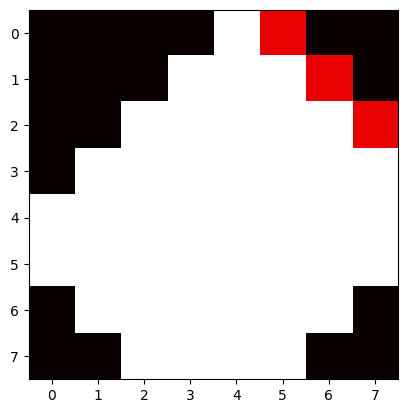

In [26]:
plt.imshow(rotated_img, cmap="hot")
rotated_img.shape